In [1]:
%matplotlib inline

from skimage import (
    io, 
    filters,
    transform
)

import cv2
import math
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

from imutils.object_detection import non_max_suppression

In [2]:
plt.rcParams['figure.figsize'] = (25, 30)

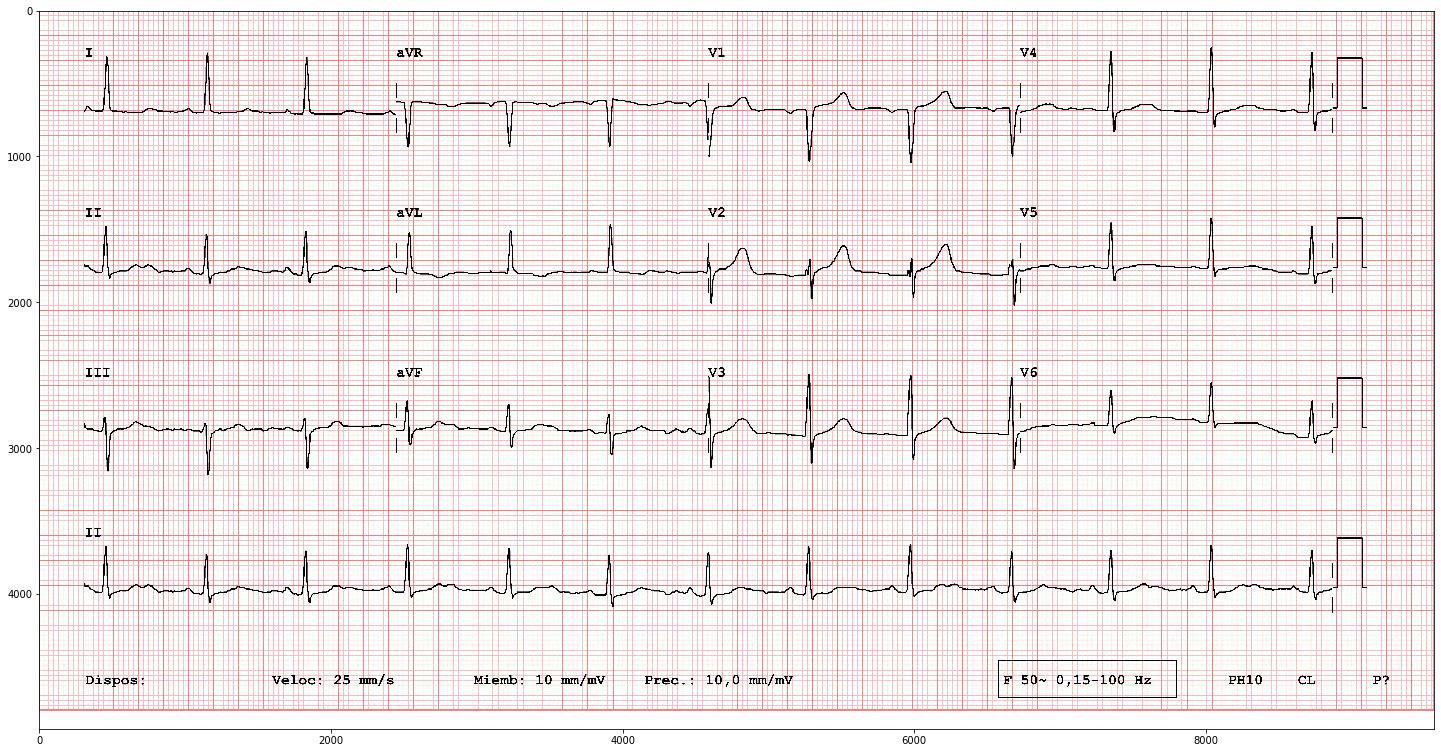

In [3]:
ECG_img = io.imread("./Data/ECG_001.jpeg")

_ = plt.imshow(
    ECG_img
)

Width: 4926 -- Height: 9567 -- Width Ratio: 10.012195121951219 -- Height Ratio 10.007322175732218


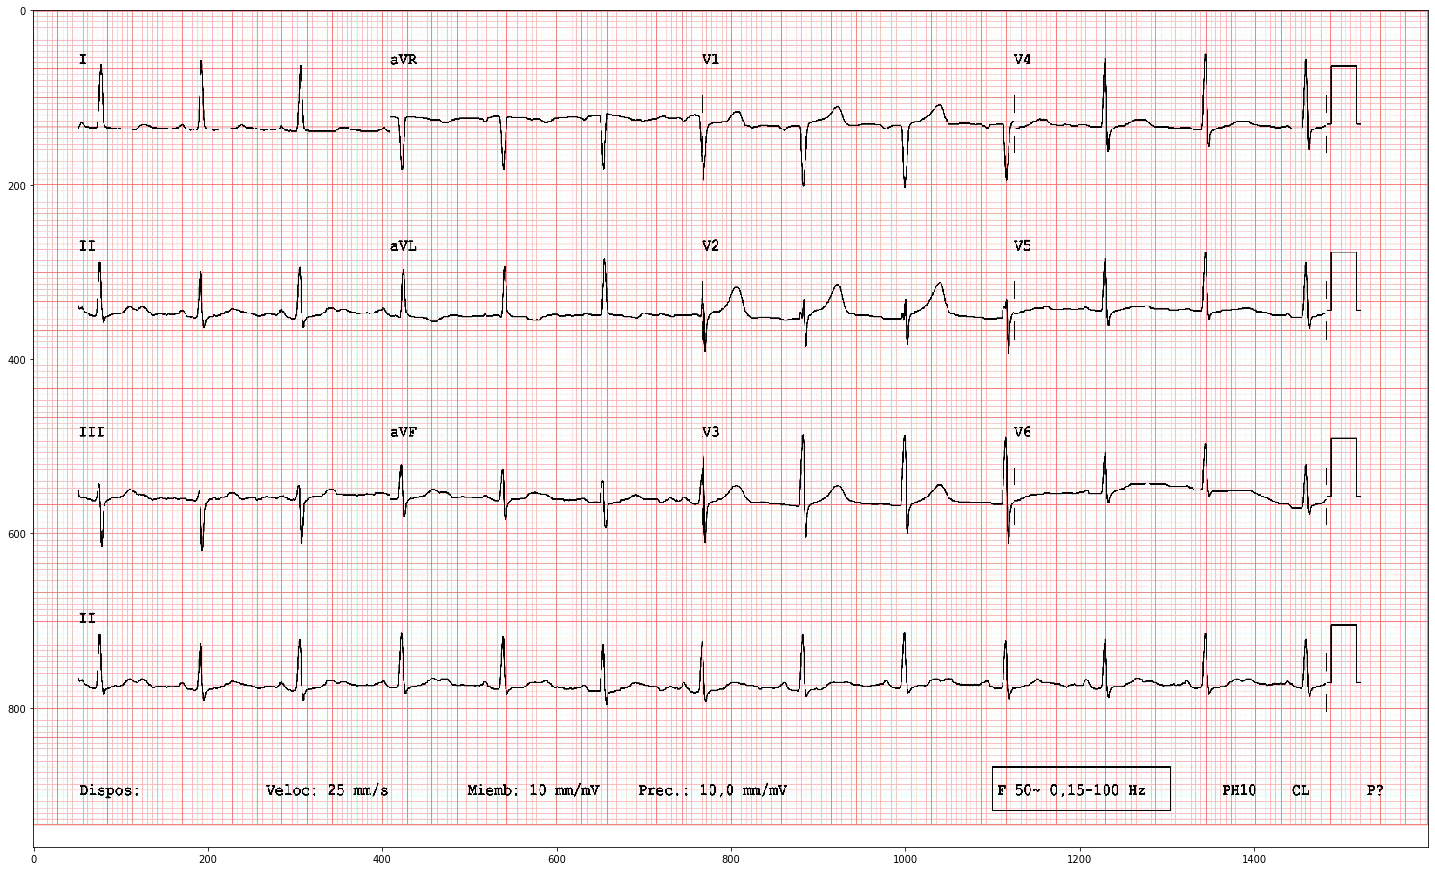

In [4]:
width, height, _ = ECG_img.shape

ECG_original = ECG_img.copy()
ECG_minimized = cv2.resize(
    ECG_img, 
    (1600, 960)
)

width_ratio = width / float(math.floor(width / 10))
height_ratio = height / float(math.floor(height / 10))

#ECG_minimized = ECG_minimized * 255
#ECG_minimized = ECG_minimized.astype(int)

print(f'Width: {width} -- Height: {height} -- Width Ratio: {width_ratio} -- Height Ratio {height_ratio}')

_ = plt.imshow(
    ECG_minimized
)

In [5]:
neural_net = cv2.dnn.readNet('./Models/frozen_east_text_detection.pb')

layers = [
    'feature_fusion/Conv_7/Sigmoid',
    'feature_fusion/concat_3'
]

In [6]:
image_blob = cv2.dnn.blobFromImage(
    ECG_minimized, 

    swapRB=True, 
    crop=False
)

neural_net.setInput(image_blob)

In [7]:
scores, geometry = neural_net.forward(layers)

In [8]:
def decode_predictions(scores, geometry):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the
        # geometrical data used to derive potential bounding box
        # coordinates that surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability,
            # ignore it
            if scoresData[x] < 0.8:
                continue

            # compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and
            # then compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height
            # of the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates
            # for the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score
            # to our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # return a tuple of the bounding boxes and associated confidences
    return (rects, confidences)

In [9]:
rects, confidences = decode_predictions(scores, geometry)

In [10]:
boxes = non_max_suppression(np.array(rects), probs=confidences)

In [11]:
boxes

array([[ 520,  887,  556,  899],
       [1166,  884, 1248,  898],
       [ 367,  889,  393,  901],
       [  67,  888,  119,  900],
       [ 813,  888,  838,  900],
       [ 597,  889,  620,  901],
       [ 697,  887,  741,  900],
       [ 268,  886,  321,  900],
       [1368,  885, 1404,  898],
       [1127,  886, 1160,  900],
       [ 409,  474,  440,  490],
       [ 412,   48,  441,   61],
       [ 569,  886,  594,  899],
       [ 626,  885,  650,  898],
       [ 499,  886,  519,  902],
       [ 839,  885,  866,  899],
       [1443,  885, 1465,  899],
       [  50,  473,   82,  491],
       [ 759,  886,  794,  898],
       [ 412,  261,  442,  276],
       [ 339,  885,  360,  899],
       [1253,  886, 1281,  901]])

In [12]:
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    #startX = int(startX * width_ratio)
    #startY = int(startY * height_ratio)
    #endX = int(endX * width_ratio)
    #endY = int(endY * height_ratio)
        
    print(startX, startY, endX, endY)
        
    # draw the bounding box on the frame
    cv2.rectangle(ECG_minimized, (startX, startY), (endX, endY), (0, 255, 0), 2)

520 887 556 899
1166 884 1248 898
367 889 393 901
67 888 119 900
813 888 838 900
597 889 620 901
697 887 741 900
268 886 321 900
1368 885 1404 898
1127 886 1160 900
409 474 440 490
412 48 441 61
569 886 594 899
626 885 650 898
499 886 519 902
839 885 866 899
1443 885 1465 899
50 473 82 491
759 886 794 898
412 261 442 276
339 885 360 899
1253 886 1281 901


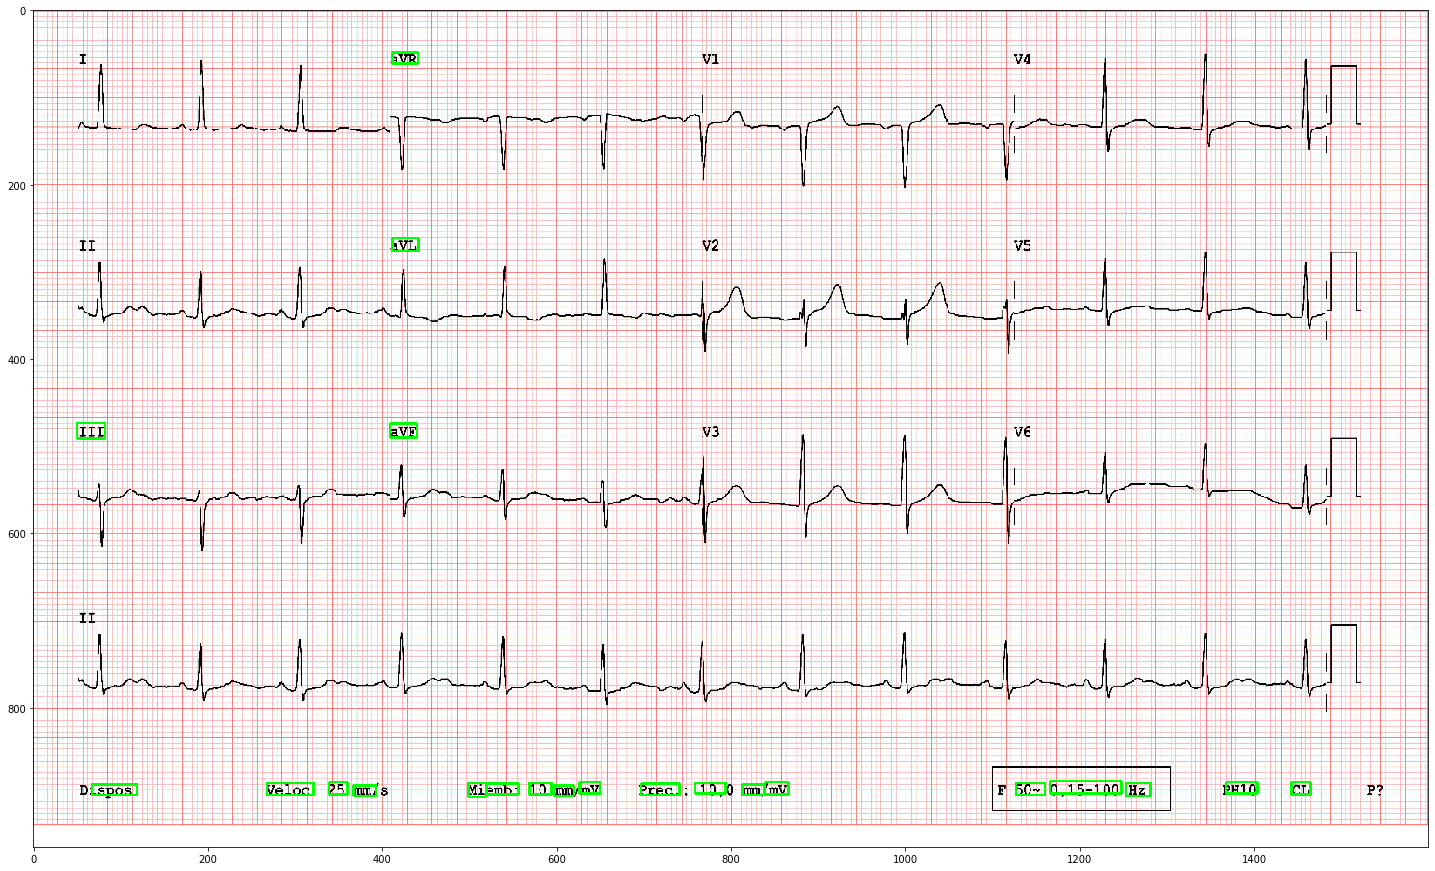

In [13]:
_ = plt.imshow(
    ECG_minimized
)